    使用python和numpy等从头实现cnn
    cnn的主要结构：
    1.特征过滤，自动提取获取卷积核
    2.卷积层特征过滤
    3.池化层处理，减少计算量
    4.激活后通过全连接层进行识别分类
    

In [38]:
import numpy as np
import skimage.data
import matplotlib.pyplot as plt
import matplotlib

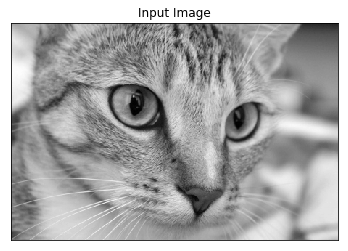

In [86]:
#读取图片
chelsea = skimage.data.astronaut()
img = skimage.color.rgb2gray(chelsea)
# plt.imshow(img).set_cmap("gray")
# plt.show()

fig0, ax0 = matplotlib.pyplot.subplots(nrows=1, ncols=1)  
ax0.imshow(img).set_cmap("gray")  
ax0.set_title("Input Image")  
ax0.get_xaxis().set_ticks([])  
ax0.get_yaxis().set_ticks([])
matplotlib.pyplot.show()
matplotlib.pyplot.close(fig0)  

    特征过滤层
    特征过滤层是通过卷积核实现的
    首先定义卷积核的数量为2，卷积核大小为3*3的数组

In [68]:
#卷积层，使用卷积核对卷积层进行卷积操作
#conv是要实现的卷积函数
def conv(img, conv_filter):
    #图片像素的维度和卷积层的通道数要相等，如果不相等则不能进行卷积操作
    if len(img.shape) > 2 or len(conv_filter.shape) > 3:
        if img.shape[-1] != conv_filter.shape[-1]:
            print("numbers of channels in image and filter must be same")
            exit()
    #卷积核必须为正方形
    if conv_filter.shape[1] != conv_filter.shape[2]:
        print("conv kernel must be square matrix")
        exit()
    
    #预先设置好保存要输出的feature_map的数组
    #feature_map的元素个数为
    #卷积核的个数*(图片长-卷积核长+1)*(图片宽-卷积核宽+1)
#     print(conv_filter[0])
    feature_maps = np.zeros((img.shape[0] - conv_filter.shape[1] + 1,
                            img.shape[1] - conv_filter.shape[1] + 1,
                            conv_filter.shape[0]))
    
    #然后分别计算
    for filter_num in range(conv_filter.shape[0]):
#         print("filter:{}".format(filter_num + 1))
        #获取当前的卷积核和图片
        curr_filter = conv_filter[filter_num]
        #如果当前filter的channel大于1的话还需要单独计算
        if len(curr_filter.shape) > 2:
            #对应位置的值相乘后累加,封装在函数conv_中
#             print(conv_(img[:,:,0], curr_filter[:,:,0]))
            conv_map = conv_(img[:,:,0], curr_filter[:,:,0])
            for ch_num in range(1, curr_filter.shape[-1]):
                conv_map = conv_map + conv_(img[:,:,ch_num], curr_filter[:,:,ch_num])
        else:
            conv_map = conv_(img, curr_filter)
        feature_maps[:,:,filter_num] = conv_map
    return feature_maps

In [99]:
#将卷积操作的函数独立出来
def conv_(img, conv_filter):
    #图片的长高
    l = img.shape[0]
    h = img.shape[1]
    filter_length = conv_filter.shape[0]
    result = np.zeros((img.shape))
    for r in range(filter_length, l):
        for c in range(filter_length, h):
            curr_region = img[r - filter_length:r, c - filter_length:c]
#             print(curr_region)
#             print("r - filter_length:{},r:{},c - filter_length:{},c:{}".format(r - filter_length, r, c - filter_length, c))
            conv_sum = curr_region * conv_filter
            result[r-filter_length+1, c-filter_length+1] = np.sum(conv_sum)
    #这里从0取到l - filter_length + 1和从0到h - filter_length + 1
    #因为赋值的时候是从(0，0)开始，到l - filter_length + 1和h-filter_length + 1
    filter_map = result[0:l - filter_length + 1, 0:h - filter_length + 1]
    return filter_map
            

In [100]:
#max_pooling层
#max层使用2*2大小的窗口，步长为2
def max_pooling(feature_maps, size = 2, stride = 2):
#     print("feature_maps.shape[0] - size + 1 / stride:{}".format(feature_maps.shape[0] - size + 1 / stride))
    pool_out = np.zeros((np.int32(feature_maps.shape[0] - size + 1 / stride), np.int32(feature_maps.shape[1] - size + 1 / stride), feature_maps.shape[-1]))
#     print(pool_out.shape)
    for map_num in range(feature_maps.shape[-1]):
        r2 = 0
        for r in range(0, feature_maps.shape[0] - size + 1, stride):
            c2 = 0
            for c in range(0, feature_maps.shape[1] - size + 1, stride):
#                 print("feature_maps[r : r + size, c : c + size, map_num]:{}".format(feature_maps[r : r + size, c : c + size, map_num]))
#                 print("r2:{}, c2:{}, map_num:{},np.max([feature_maps[r : r + size, c : c + size, map_num]]):{}".format(r2, c2, map_num, np.max([feature_maps[r : r + size, c : c + size, map_num]])))
                pool_out[r2, c2, map_num] = np.max([feature_maps[r : r + size, c : c + size, map_num]])
                c2 = c2 + 1
            r2 = r2 + 1
    #这里从0取到r2和从0取到c2
    return pool_out[0:r2, 0:c2]

In [101]:
#relu层
#relu=max(0,x)
def relu(feature_maps):
    relu_out = np.zeros(feature_maps.shape)
    for map_num in range(feature_maps.shape[-1]):
        for r in range(0, feature_maps.shape[0]):
            for c in range(0, feature_maps.shape[1]):
                relu_out[r, c, map_num] = np.max([feature_maps[r, c, map_num], 0])
    return relu_out

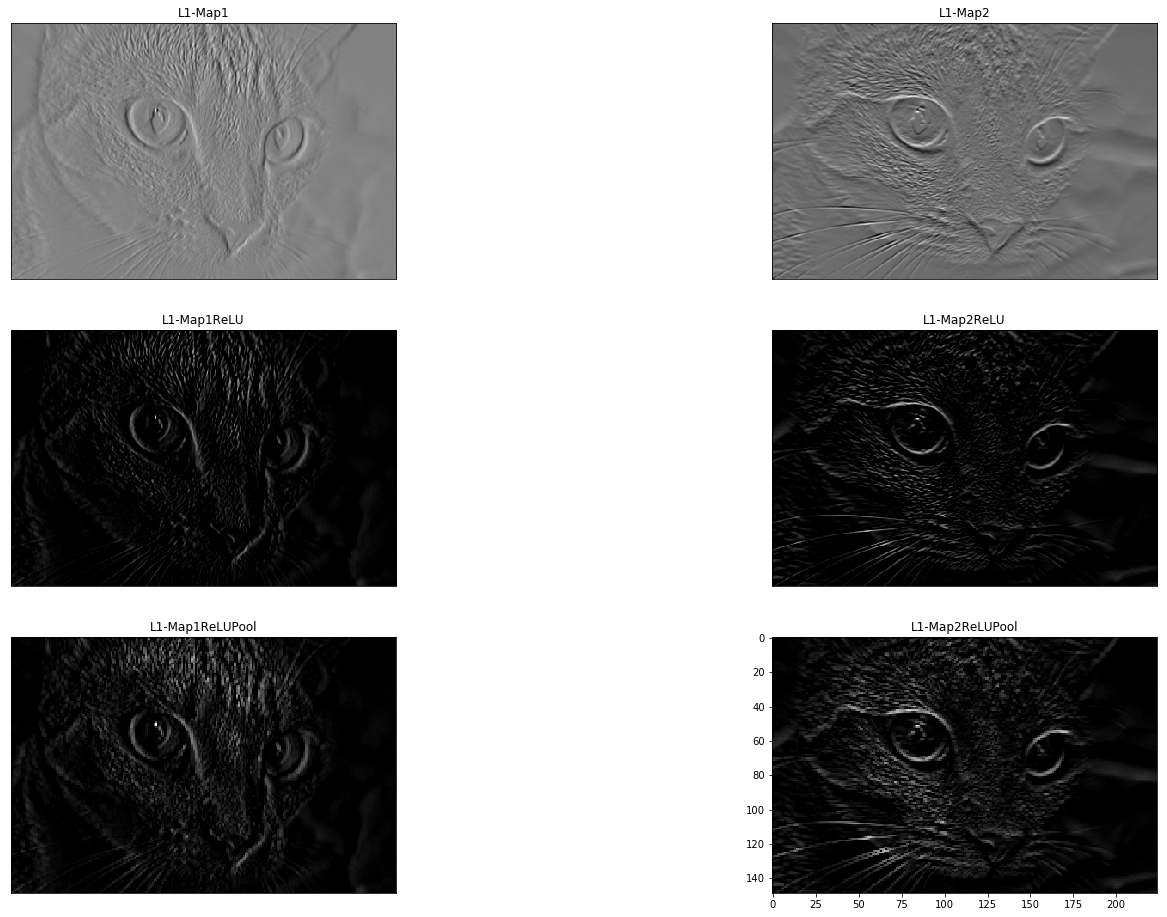

In [102]:
#多层堆叠
l1_filter = np.zeros([2, 3, 3])
l1_filter[0,:,:] = np.array([[[-1, 0, 1],[-1, 0, 1], [-1, 0, 1]]])
l1_filter[1,:,:] = np.array([[[1, 1, 1],[0, 0, 0], [-1, -1, -1]]])
# print(l1_filter)
l1_feature_map = conv(img, l1_filter)
l1_feature_map_relu = relu(l1_feature_map)
# print(l1_feature_map_relu)
l1_feature_map_relu_max_pooling = max_pooling(l1_feature_map_relu)
# print(l1_feature_map_relu_max_pooling)
fig1, ax1 = matplotlib.pyplot.subplots(nrows=3, ncols=2, figsize=(25, 16))  
ax1[0, 0].imshow(l1_feature_map[:, :, 0]).set_cmap("gray")  
ax1[0, 0].get_xaxis().set_ticks([])  
ax1[0, 0].get_yaxis().set_ticks([])  
ax1[0, 0].set_title("L1-Map1")  

ax1[0, 1].imshow(l1_feature_map[:, :, 1]).set_cmap("gray")  
ax1[0, 1].get_xaxis().set_ticks([])  
ax1[0, 1].get_yaxis().set_ticks([])  
ax1[0, 1].set_title("L1-Map2")  
  
ax1[1, 0].imshow(l1_feature_map_relu[:, :, 0]).set_cmap("gray")  
ax1[1, 0].get_xaxis().set_ticks([])  
ax1[1, 0].get_yaxis().set_ticks([])  
ax1[1, 0].set_title("L1-Map1ReLU")  
  
ax1[1, 1].imshow(l1_feature_map_relu[:, :, 1]).set_cmap("gray")  
ax1[1, 1].get_xaxis().set_ticks([])  
ax1[1, 1].get_yaxis().set_ticks([])  
ax1[1, 1].set_title("L1-Map2ReLU")  
  
ax1[2, 0].imshow(l1_feature_map_relu_max_pooling[:, :, 0]).set_cmap("gray")  
ax1[2, 0].get_xaxis().set_ticks([])  
ax1[2, 0].get_yaxis().set_ticks([])  
ax1[2, 0].set_title("L1-Map1ReLUPool")  
  
ax1[2, 1].imshow(l1_feature_map_relu_max_pooling[:, :, 1]).set_cmap("gray")  
ax1[2, 0].get_xaxis().set_ticks([])  
ax1[2, 0].get_yaxis().set_ticks([])  
ax1[2, 1].set_title("L1-Map2ReLUPool")  
  
matplotlib.pyplot.show()
matplotlib.pyplot.close(fig1)  

#第二层
l2_filter = np.random.rand(3, 5, 5, l1_feature_map_relu_max_pooling.shape[-1])
l2_feature_map = conv(l1_feature_map_relu_max_pooling, l2_filter)
l2_feature_map_relu = relu(l2_feature_map)
l2_feature_map_relu_max_pooling = max_pooling(l2_feature_map_relu)

# #第三层
# l3_filter = np.random.rand(3, 5, 5, l2_feature_map_relu_max_pooling.shape[-1])
# l3_feature_map = conv(l2_feature_map_relu_max_pooling, l3_filter)
# l3_feature_map_relu = relu(l3_feature_map)
# l3_feature_map_relu_max_pooling = max_pooling(l3_feature_map_relu)

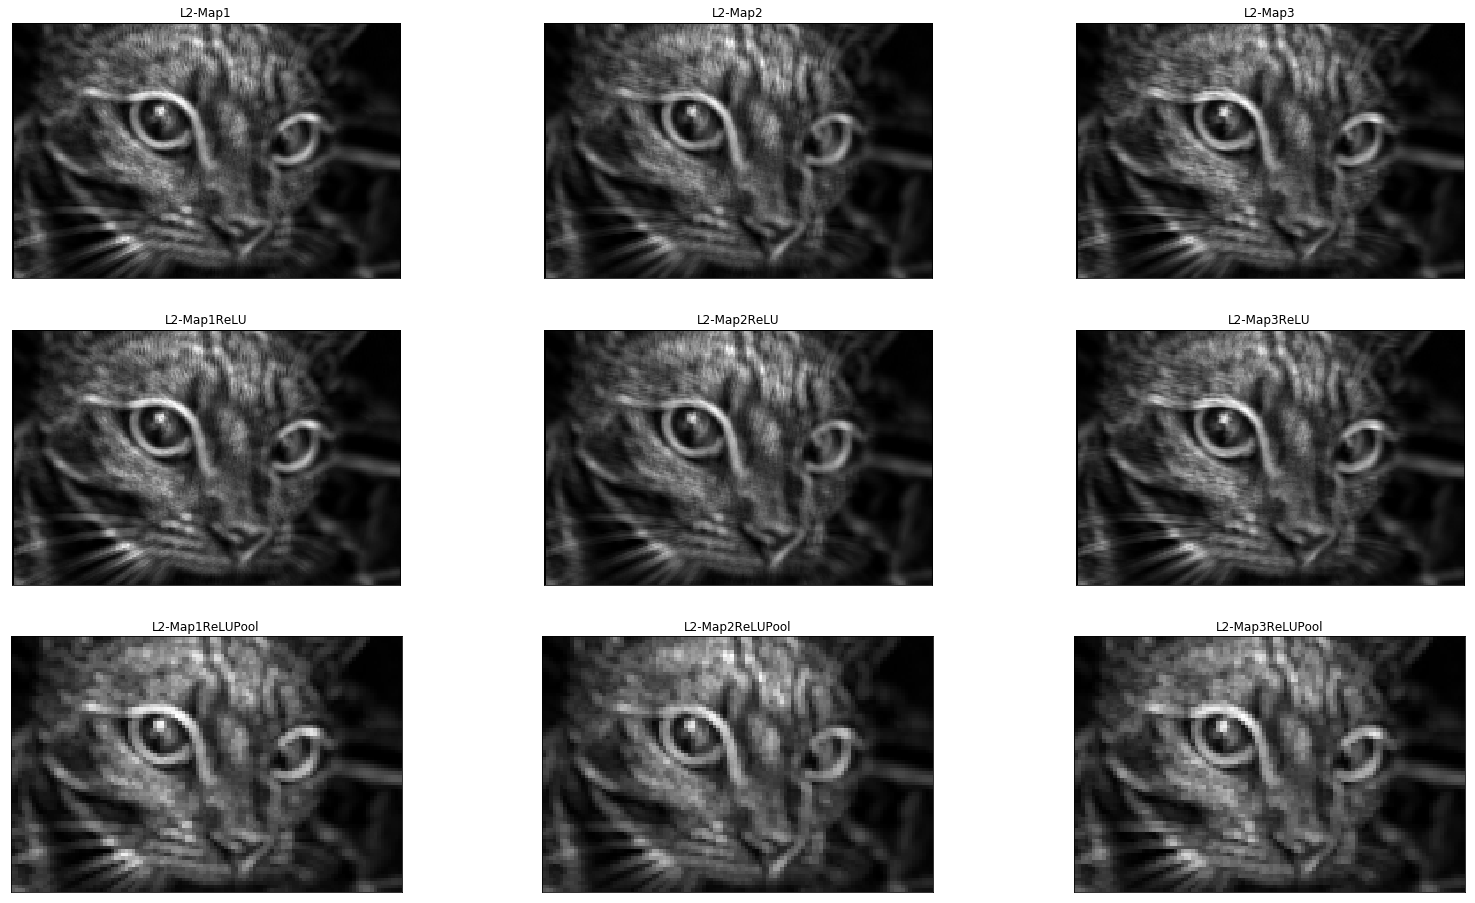

In [103]:
#第二层

l2_filter = np.random.rand(3, 5, 5, l1_feature_map_relu_max_pooling.shape[-1])
l2_feature_map = conv(l1_feature_map_relu_max_pooling, l2_filter)
l2_feature_map_relu = relu(l2_feature_map)
l2_feature_map_relu_max_pooling = max_pooling(l2_feature_map_relu)
fig2, ax2 = matplotlib.pyplot.subplots(nrows=3, ncols=3, figsize=(27, 16))  

ax2[0, 0].imshow(l2_feature_map[:, :, 0]).set_cmap("gray")  
ax2[0, 0].get_xaxis().set_ticks([])  
ax2[0, 0].get_yaxis().set_ticks([])  
ax2[0, 0].set_title("L2-Map1")  
  
ax2[0, 1].imshow(l2_feature_map[:, :, 1]).set_cmap("gray")  
ax2[0, 1].get_xaxis().set_ticks([])  
ax2[0, 1].get_yaxis().set_ticks([])  
ax2[0, 1].set_title("L2-Map2")  
  
ax2[0, 2].imshow(l2_feature_map[:, :, 2]).set_cmap("gray")  
ax2[0, 2].get_xaxis().set_ticks([])  
ax2[0, 2].get_yaxis().set_ticks([])  
ax2[0, 2].set_title("L2-Map3")  
  
ax2[1, 0].imshow(l2_feature_map_relu[:, :, 0]).set_cmap("gray")  
ax2[1, 0].get_xaxis().set_ticks([])  
ax2[1, 0].get_yaxis().set_ticks([])  
ax2[1, 0].set_title("L2-Map1ReLU")  
  
ax2[1, 1].imshow(l2_feature_map_relu[:, :, 1]).set_cmap("gray")  
ax2[1, 1].get_xaxis().set_ticks([])  
ax2[1, 1].get_yaxis().set_ticks([])  
ax2[1, 1].set_title("L2-Map2ReLU")  
  
ax2[1, 2].imshow(l2_feature_map_relu[:, :, 2]).set_cmap("gray")  
ax2[1, 2].get_xaxis().set_ticks([])  
ax2[1, 2].get_yaxis().set_ticks([])  
ax2[1, 2].set_title("L2-Map3ReLU")  
  
ax2[2, 0].imshow(l2_feature_map_relu_max_pooling[:, :, 0]).set_cmap("gray")  
ax2[2, 0].get_xaxis().set_ticks([])  
ax2[2, 0].get_yaxis().set_ticks([])  
ax2[2, 0].set_title("L2-Map1ReLUPool")  
  
ax2[2, 1].imshow(l2_feature_map_relu_max_pooling[:, :, 1]).set_cmap("gray")  
ax2[2, 1].get_xaxis().set_ticks([])  
ax2[2, 1].get_yaxis().set_ticks([])  
ax2[2, 1].set_title("L2-Map2ReLUPool")  
  
ax2[2, 2].imshow(l2_feature_map_relu_max_pooling[:, :, 2]).set_cmap("gray")  
ax2[2, 2].get_xaxis().set_ticks([])  
ax2[2, 2].get_yaxis().set_ticks([])  
ax2[2, 2].set_title("L2-Map3ReLUPool")  
  
matplotlib.pyplot.show()
matplotlib.pyplot.close(fig2)  

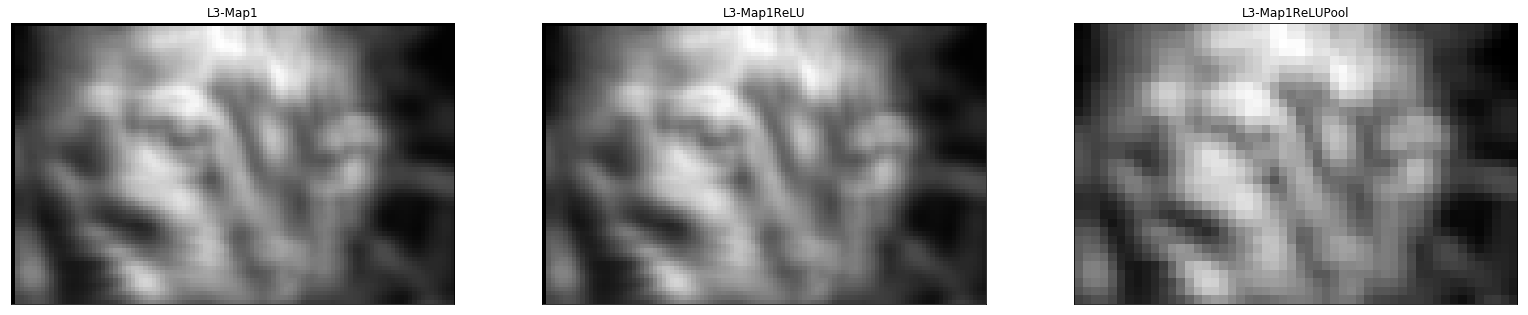

In [104]:
# Layer 3  
l3_filter = np.random.rand(1, 7, 7, l2_feature_map_relu_max_pooling.shape[-1])
l3_feature_map = conv(l2_feature_map_relu_max_pooling, l3_filter)
l3_feature_map_relu = relu(l3_feature_map)
l3_feature_map_relu_pool = max_pooling(l3_feature_map_relu)

fig3, ax3 = matplotlib.pyplot.subplots(nrows=1, ncols=3, figsize=(27, 16))  
ax3[0].imshow(l3_feature_map[:, :, 0]).set_cmap("gray")  
ax3[0].get_xaxis().set_ticks([])  
ax3[0].get_yaxis().set_ticks([])  
ax3[0].set_title("L3-Map1")  
  
ax3[1].imshow(l3_feature_map_relu[:, :, 0]).set_cmap("gray")  
ax3[1].get_xaxis().set_ticks([])  
ax3[1].get_yaxis().set_ticks([])  
ax3[1].set_title("L3-Map1ReLU")  
  
ax3[2].imshow(l3_feature_map_relu_pool[:, :, 0]).set_cmap("gray")  
ax3[2].get_xaxis().set_ticks([])  
ax3[2].get_yaxis().set_ticks([])  
ax3[2].set_title("L3-Map1ReLUPool")

matplotlib.pyplot.show()
matplotlib.pyplot.close(fig3)